# Background Theory

We again want to advect a passive tracer field using a 2D streamfunction. The passive tracer takes the form:

$$ q(x,y) = \exp\left(-\frac{(x-x_0)^2+(y-y_0)^2}{\sigma^2}\right) $$

where $x_0$ and $y_0$ are the initial position of the tracer and $\sigma$ is the width of the tracer.

The streamfunction is also modified to depend on x, as well as y, and is given by:

$$ \Psi(x,y) = \frac{\phi_0}{f_0} \left( 1 - A \exp{\left[- \frac{(x-{x_0}_{\psi})^2 + (y-{y_0}_{\psi})^2}{2 \sigma^2_{\psi}}\right]}\right) $$

Thus, given some domain parameters:

- $\phi_0 = 10^{5}$ metres squared per second squared
- $f_0 = 10^{-4}$ per second
- ${x_0}_{\psi} = 1.25 \times 10^{7}$ metres
- ${x_0}_{q} = 1.375 \times 10^{7}$ metres
- ${y_0}_{\psi} = {y_0}_{q} =  2.5 \times 10^{6}$ metres
- $A = 3 \times 10^{-2}$ per second
- $\sigma_{\psi} = 7.5 \times 10^{5}$ metres
- $\sigma_{q} = 5 \times 10^{5}$ metres

And a grid with the following configuration:
- $\Delta x = \Delta y = 10^{5}$ metres

We can, again, advect the passive tracer around our 2D domain using the Semi-Lagrangian interpolation scheme.

# Solution

Imports:

In [284]:
import sys
sys.path.append('Functions') # add 'Functions' folder to system-recognised path in order to import .py file and functions from within a nested folder.

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

from Functions.grid_interpolation import *

Define constants:

In [285]:
# constants
phi_0     = 1e5
f_0       = 1e-4
beta      = 1.6e-11
x_0_psi   = 1.25e7
x_0_q     = 1.375e7
y_0_psi   = y_0_q = 2.5e6
A         = 3e-2
sigma_psi = 7.5e5
sigma_q   = 5e5

# set up some interpolation orders for experiments
interpolation_order = 3
test_order          = 1
second_test_order   = 5

# duration of simulation
duration  = 6 * 24 * 60 * 60 # 6 days in seconds
dt        = 2* 60 * 60 # 1 hour in seconds
num_steps = duration/dt # number of timesteps

Define the grid:

In [286]:
# common grid spacing
grid_space = 1e4

# adding 1e5 to both limits so that np.arrange() includes the upper limit
upper_x_limit = 2.5e7 + grid_space
upper_y_limit = 5e6 + grid_space

x = np.arange(0, upper_x_limit, grid_space)
y = np.arange(0, upper_y_limit, grid_space)

# define an X array where :
Y, X = np.meshgrid(y, x)

As always, we define the streamfunction and passive tracer using the analytical solutions:

In [287]:
psi  = phi_0/f_0 * (1 - (A * np.exp(-((X-(x_0_psi))**2 + (Y-y_0_psi)**2)/(2 * (sigma_psi**2)))))
q_xy = np.exp(-((X-(x_0_q))**2 + (Y-y_0_q)**2)/(2 * (2 * sigma_q**2))) # note that both of these variables need to be periodic in the x direction

Set up a periodic form of the streamfunction:

Quick sanity check from visualisations:

$ \Psi $

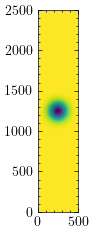

In [288]:
plt.axes(aspect='equal')
plt.pcolormesh(psi)

$ q_{xy} $

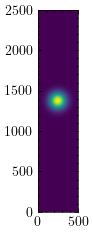

In [289]:
plt.axes(aspect='equal')
plt.pcolormesh(q_xy)

Again, we differentiate (using numerical methods) the streamfunction to get the zonal and meridional velocities. For the zonal velocity we have:

$$ u = \frac{\Psi_{j, i+1} - \Psi_{j, i-1}}{2 \Delta y} $$

For the meridional velocity we have:

$$ v = -\frac{\Psi_{j+1, i} - \Psi_{j-1, i}}{2 \Delta x} $$

In [290]:
def generate_velocity(streamfunction, y, x):
    N = np.shape(y)[1]  # length in the y direction
    M = np.shape(x)[0]
    dx = dy = y[0, 1] - y[0, 0]  # extract grid space step from y array
    
    # Implement centred difference scheme for u, ignoring the boundary conditions as u 
    # is not defined on the boundary
    u = -1 * ((streamfunction[:, 2:N] - streamfunction[:, 0:(N-2)]) / (2 * dy))

    # Define boundary conditions for v
    v_first = (streamfunction[1, 1:(N-1)] - streamfunction[-1, 1:(N-1)]) / (2 * dx)
    v_last = (streamfunction[0, 1:(N-1)] - streamfunction[-2, 1:(N-1)]) / (2 * dx)

    # Implement centred difference scheme for middle values of v
    v_interior = (streamfunction[2:M, 1:(N-1)] - streamfunction[0:(M-2), 1:(N-1)]) / (2 * dx)
    
    # Combine interior and boundary values for v
    v = np.vstack([v_first, v_interior, v_last])

    return u, v

U, V = generate_velocity(psi, Y, X)

Visualising results:

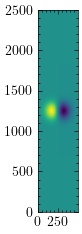

In [291]:
plt.axes(aspect='equal')
plt.pcolormesh(U)

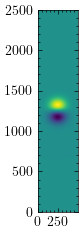

In [292]:
plt.axes(aspect='equal')
plt.pcolormesh(V)

Now we can advect the passive tracer using the Semi-Lagrangian scheme. We first begin by computing the departure points.

In [293]:
def compute_dep_pts(u, v, dt, x, y, dx, interp_order, max_iterations=100):

    # First we set a convergence threshold
    convergence_threshold = 0.01 * dx

    # Set an initial guess of wind at the midpoint between departure and arrival points to be the 
    # wind at the arrival point
    u_mid, v_mid = u, v

    # Set the first guess of departure points 
    x_dep = x - (u_mid * dt)
    y_dep = y - (v_mid * dt)

    # Iterate, updating departure points until convergence 
    for _ in range(max_iterations):
        # Interpolate wind to departure points using custom interpolation
        u_dep, v_dep = interpolate([u, v], x, y, x_dep, y_dep, interp_order=interp_order, wrap=[True, False])

        # Estimate wind at midpoint
        u_mid = 0.5 * (u_dep + u)
        v_mid = 0.5 * (v_dep + v)

        # Compute new estimate departure points
        x_dep_new = x_dep - u_mid * dt
        y_dep_new = y_dep - v_mid * dt

        # Compute change from (x_dep, y_dep) to (x_dep_new, y_dep_new) across the grid
        max_change = np.max(np.sqrt((x_dep_new - x_dep)**2 + (y_dep_new - y_dep)**2))

        # Check for convergence
        if max_change < convergence_threshold * dx:
            break

        # Update departure points
        x_dep, y_dep = x_dep_new, y_dep_new

    return x_dep, y_dep

# Compute departure points
x_dep, y_dep = compute_dep_pts(u = U, v=V, dt=dt, x=X[:,1:-1], y=Y[:,1:-1], dx=grid_space, interp_order=interpolation_order)

Advect the tracer field:

In [294]:
def advect_tracer(num_steps, q, x, y, x_dep, y_dep, interp_order):

    for time_step in range(int(num_steps)):

        # Interpolate q to departure points
        q_dep = interpolate([q[:,1:-1]], x[:,1:-1], y[:,1:-1], x_dep, y_dep, interp_order=interp_order, wrap=[True, False])

        # Compute new q
        q[:,1:-1] = q_dep[0]

    return q

In [295]:
# advected_tracer_field = advect_tracer(num_steps, q_xy, X, Y, x_dep, y_dep, interpolation_order)

In [296]:
import time

# List to store results and computation times for each interpolation order
results = []
computation_times = []

# Interpolation orders to test
interpolation_orders_to_test = [interpolation_order, test_order, second_test_order]

# Loop over each interpolation order
for interp_order in interpolation_orders_to_test:
    # Record start time
    start_time = time.time()

    # Compute departure points for the current interpolation order
    x_dep, y_dep = compute_dep_pts(u=U, v=V, dt=dt, x=X[:, 1:-1], y=Y[:, 1:-1], dx=grid_space, interp_order=interp_order)

    # Advect the tracer field using the current interpolation order
    advected_tracer_field = advect_tracer(num_steps, q_xy, X, Y, x_dep, y_dep, interp_order)

    # Record end time
    end_time = time.time()

    # Append results and computation time to the lists
    results.append(advected_tracer_field)
    computation_times.append(end_time - start_time)

# Plotting code can be added here using the results list

# Print computation times for each interpolation order
for i, interp_order in enumerate(interpolation_orders_to_test):
    print(f"Interpolation Order {interp_order}: {computation_times[i]} seconds")

# Additional experiments can be added here


Interpolation Order 3: 30.619824171066284 seconds
Interpolation Order 1: 9.232985734939575 seconds
Interpolation Order 5: 75.60129594802856 seconds


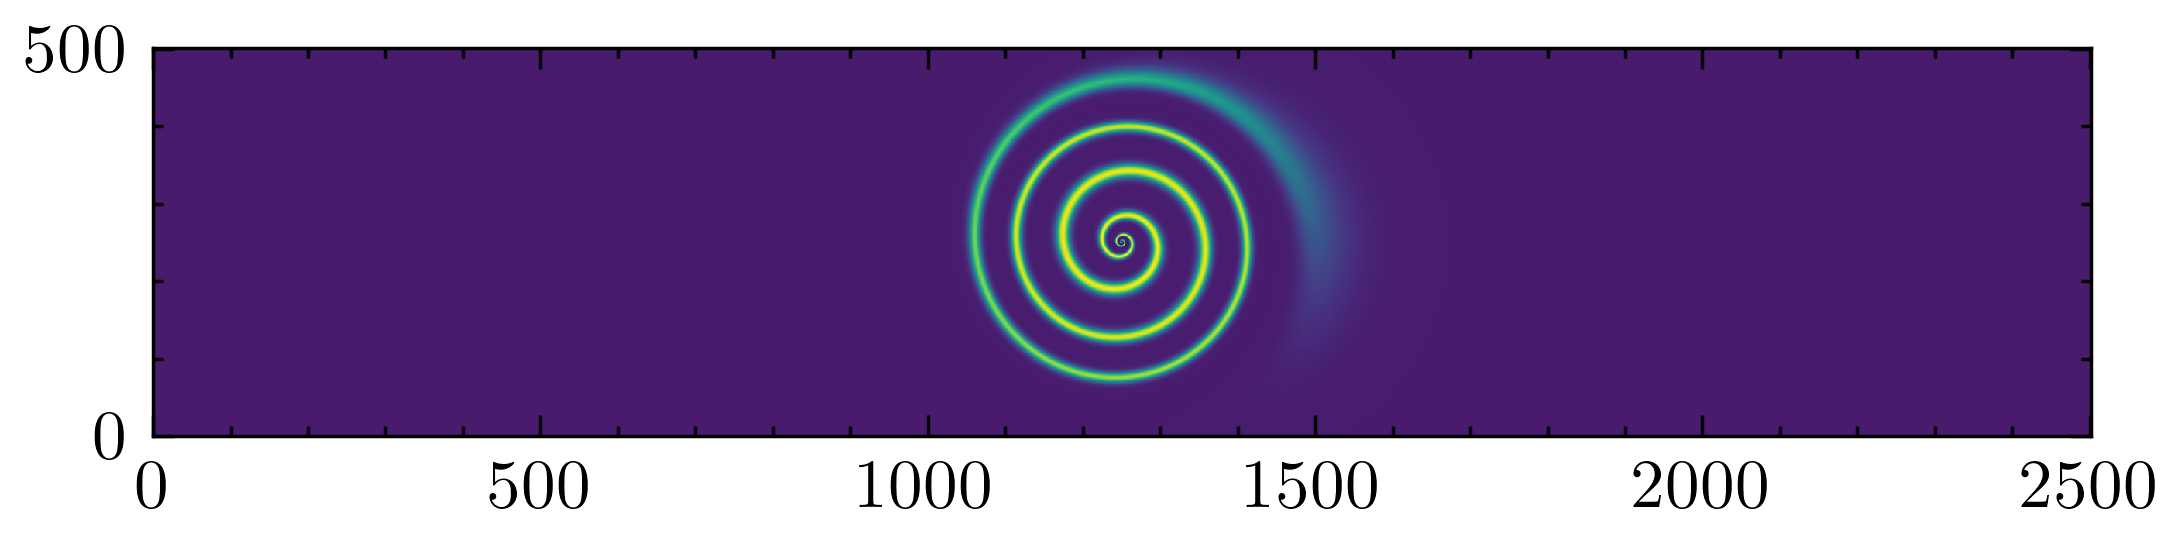

In [297]:
plt.figure(figsize=(5, 5), dpi=500)
plt.axes(aspect='equal')
plt.pcolormesh(results[0].T)
plt.pcolormesh(results[1].T)
plt.pcolormesh(results[2].T)